# Part 1 ‑ Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [2]:
login_df = pd.read_json("logins.json")

In [3]:
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
login_df.shape

(93142, 1)

In [5]:
login_df  = login_df.set_index(['login_time'])

In [6]:
login_df['login_count'] = 1

In [7]:
login_df_15T = login_df.resample('15T').sum()
login_df_15T.reset_index()
login_df_15T.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


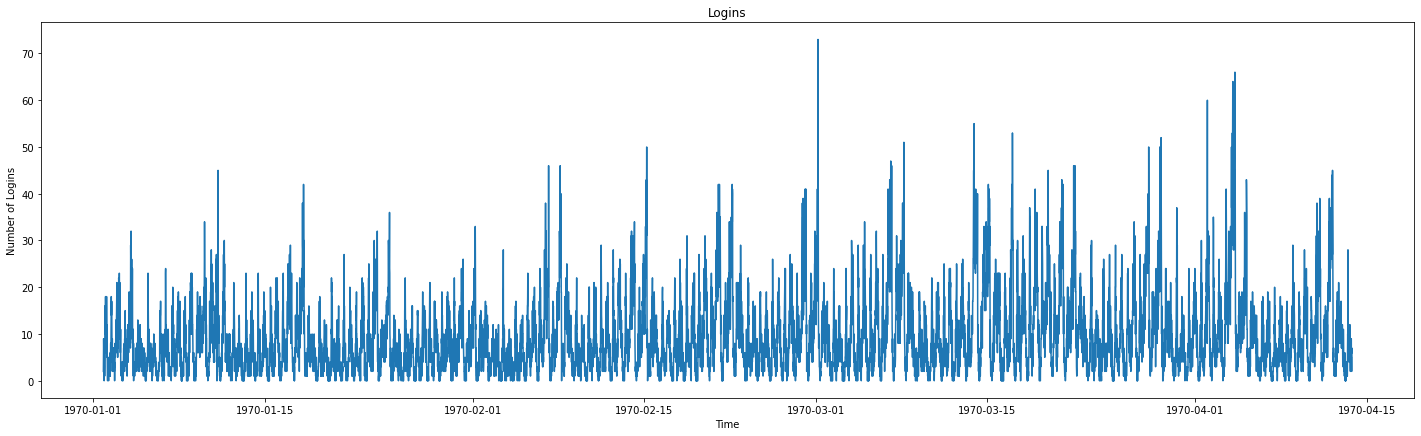

In [8]:
plt.figure(figsize=(20,6))
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins')
# puts the data in the figure
plt.plot(login_df_15T.index, login_df_15T.login_count)

#### There seem to be some underlying pattern which is not clear. We will now unwind the dataset for better understanding.
#### Lets look at month wise first

In [9]:
logins_monthly = login_df.resample('M').sum()

In [10]:
logins_monthly

,login_count
login_time,
1970-01-31,21239
1970-02-28,24673
1970-03-31,33723
1970-04-30,13507


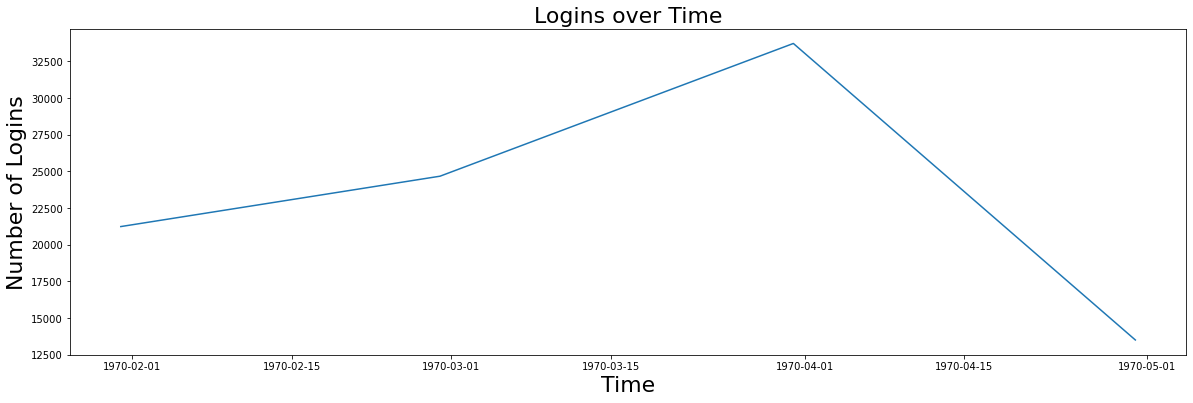

In [11]:
# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (20,6))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)
plt.plot(logins_monthly.index, logins_monthly.login_count, label='Months')

In [12]:

logins_monthly

,login_count
login_time,
1970-01-31,21239
1970-02-28,24673
1970-03-31,33723
1970-04-30,13507


In [13]:

# bin data by the day
logins_monthly = login_df.resample('M').sum()
logins_daily = login_df.resample('D').sum()
logins_biz_day = login_df.resample('B').sum()
fridays = login_df.resample('W-FRI').sum()
saturdays = login_df.resample('W-SAT').sum()
sundays = login_df.resample('W-SUN').sum()

(array([719194., 719208., 719222., 719236., 719253., 719267., 719283.]),
 <a list of 7 Text major ticklabel objects>)

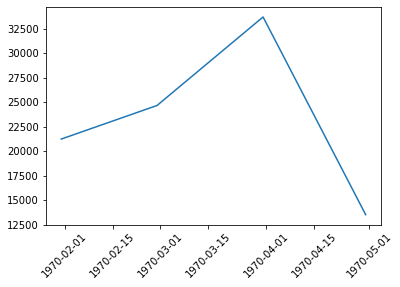

In [14]:
plt.plot(logins_monthly.index, logins_monthly.login_count, label = 'monthly Frequencies')
plt.xticks(rotation=45)

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  """
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  import sys


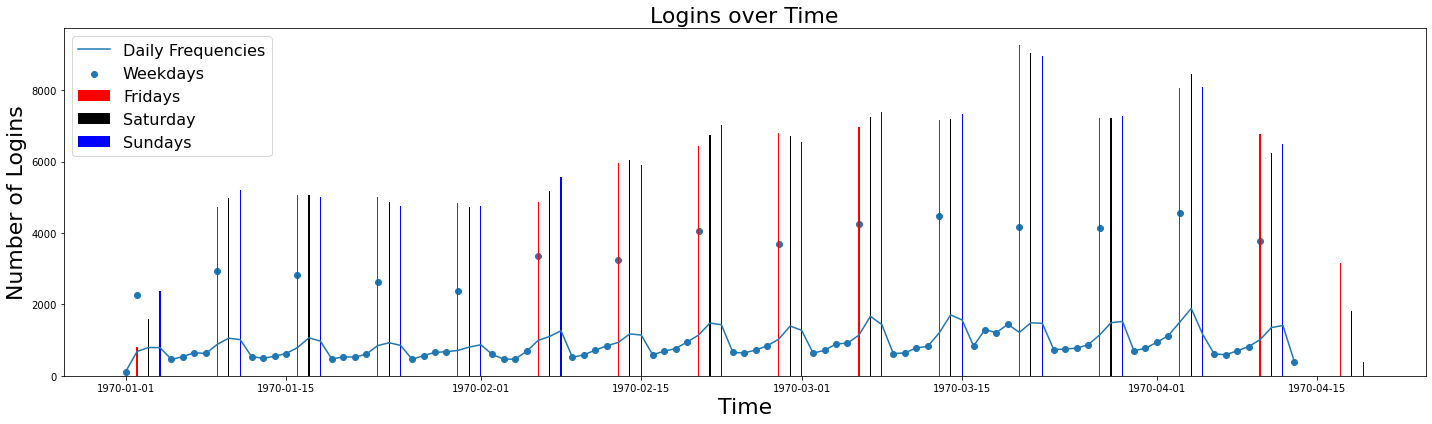

In [15]:
fig, ax = plt.subplots(figsize = (20,6))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)
plt.bar(fridays.index, fridays.login_count, align= 'center', width = 0.1, label = "Fridays", color = 'R')
plt.bar(saturdays.index, saturdays.login_count, label = 'Saturday', align = 'center', width = 0.1, color = 'Black')
plt.bar(sundays.index, sundays.login_count, label = "Sundays", align= 'center', width = 0.1, color = 'B')

plt.plot(logins_daily.index, logins_daily.login_count, label = 'Daily Frequencies')
plt.scatter(logins_biz_day.index, logins_biz_day.login_count, label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()

#### it is seen that on Fridays there are maximum logins. the weekends are busier than weekdays
#### we can now check for hourly cycle

In [16]:
# resample  hourly
daily_logins = login_df.resample('H').sum()
# make a column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week
# add column with just the hour (omiting the date)
daily_logins['hour'] = [time.hour for time in daily_logins.index]
daily_counts = daily_logins[['login_count','day_of_week']]
daily_counts = daily_counts.groupby('day_of_week').sum().reset_index()
daily_counts

,day_of_week,login_count
0,0,8823
1,1,9268
2,2,10339
3,3,11960
4,4,15208
5,5,19377
6,6,18167


In [17]:
# create dataframe of the average number of logins for each hour of each day
daily_counts['day_of_week'] = ['Mon', 'Tues', 'Wed','Thurs','Fri', 'Sat', 'Sun']
daily_counts

,day_of_week,login_count
0,Mon,8823
1,Tues,9268
2,Wed,10339
3,Thurs,11960
4,Fri,15208
5,Sat,19377
6,Sun,18167


Text(0.5, 1.0, 'Count of logins vs. Weekday ')

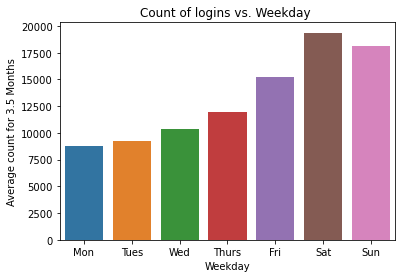

In [18]:
# count of logins as per the days of the week
# Visualizing count of logins vs. weekday
sns.barplot(x='day_of_week', y='login_count', data=daily_counts)
plt.ylabel('Average count for 3.5 Months')
plt.xlabel('Weekday')
plt.title('Count of logins vs. Weekday ')

In [19]:
# Now we look for hourly data
# resample  hourly
hourly_logins = login_df_15T.resample('H').sum()
# add column with just the hour (omiting the date)
hourly_logins['hour'] = [time.hour for time in hourly_logins.index]
hourly_counts = hourly_logins[['login_count','hour']]
hourly_counts = hourly_counts.groupby('hour').sum().reset_index()
hourly_counts.head()

,hour,login_count
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


Text(0.5, 1.0, 'Average count of logins vs. Hour of day ')

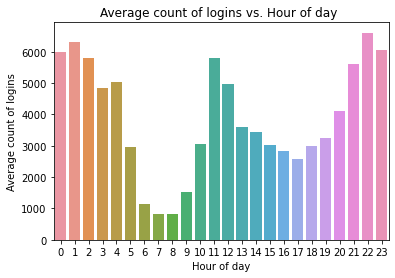

In [20]:
# Visualizing count of logins per hour of the day
sns.barplot(x='hour', y='login_count', data=hourly_counts)
plt.ylabel('Average count of logins')
plt.xlabel('Hour of day')
plt.title('Average count of logins vs. Hour of day ')

###  Conclusion
#### User logins increase in the early morning between 1 to 4 am
#### user logins increase between 11-12 pm
#### user logins increase during latenight between 20-24 hrs

# Part2 : Experiments and metric design

## Solution:

Why the Company wants more driver partners to be available in both cities.

* To increase driver/rider acceptance-rates
* To increase driver/rider sign-ups
* To reduce driver/rider wait times
* To increase profit

Ultimately, increasing acceptance-rates and sign-ups while reducing wait times would lead to profit. 

In order to increase profit, the additional income  in during the experiment must outweigh the toll cost reimbursements. 

The profit after the reimbursement can be used as a metric.

The hypothesis test can be used to verify the aboe metric.

Null  Hypothesis :There is no profit after the reimbursement
Alternate Hypothesis : There is significant profit after the reimbursement
    
Z-test can be performed to evaluate the above hypothesis to determine the p-value 
if p-value  < 0.05 , the null hypothesis will be rejected and alternate will be accepted.

The above tests need to performed for larger data of the year.


    
    

# Part 3: Predictive modeling

In [21]:
filename = 'ultimate_data_challenge.json'

user_data = pd.read_json(filename)

In [22]:
user_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [23]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [24]:
user_data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [25]:
#Handle Missing numerical values
user_data['avg_rating_of_driver'].fillna(user_data['avg_rating_of_driver'].mean(),inplace=True)
user_data['avg_rating_by_driver'].fillna(user_data['avg_rating_by_driver'].mean(),inplace=True)

In [26]:
user_data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.564977,0.222336,19.958811,37.081503,5.707357,0.445753
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [27]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [28]:
user_data.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [29]:
user_data.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [30]:
# we will ipute with 'iphone' to fill the missing values of phone column
user_data['phone'].fillna('iphone',inplace=True)

In [31]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [32]:
# convert dates to datetime objects
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])

# find the date the data was pulled
pull_date = user_data.last_trip_date.max()

# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

In [33]:
pull_date

Timestamp('2014-07-01 00:00:00')

In [34]:
cut_off_day

Timestamp('2014-06-01 00:00:00')

In [35]:
# add active status to dataframe 0= inactive, 1 = active
user_data['active_status'] = (user_data.last_trip_date > cut_off_day).astype('int')

In [36]:
user_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_status
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [37]:
len(user_data[user_data.active_status == 1])

18310

In [38]:
len(user_data)

50000

In [39]:
pct_retained = (len(user_data[user_data.active_status == 1]) * 100)/len(user_data)
print("The percentage of the users retained is : ",pct_retained, "%")

The percentage of the users retained is :  36.62 %


In [40]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  active_status           50000 non-null  int32 

In [41]:
# One-hot-encode all categorical features
user_data = pd.get_dummies(user_data, columns = ['city', 'phone', 'ultimate_black_user'])
user_data.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_iphone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,1,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,0,1,0


In [42]:
# Dropping date-time features 
user_data.drop('last_trip_date', axis=1, inplace=True)
user_data.drop('signup_date', axis=1, inplace=True)

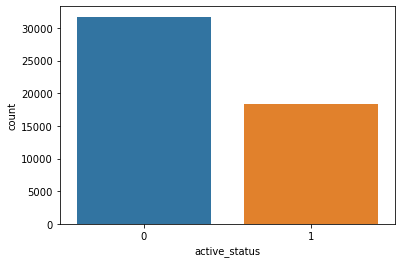

In [43]:
sns.countplot(user_data.active_status)

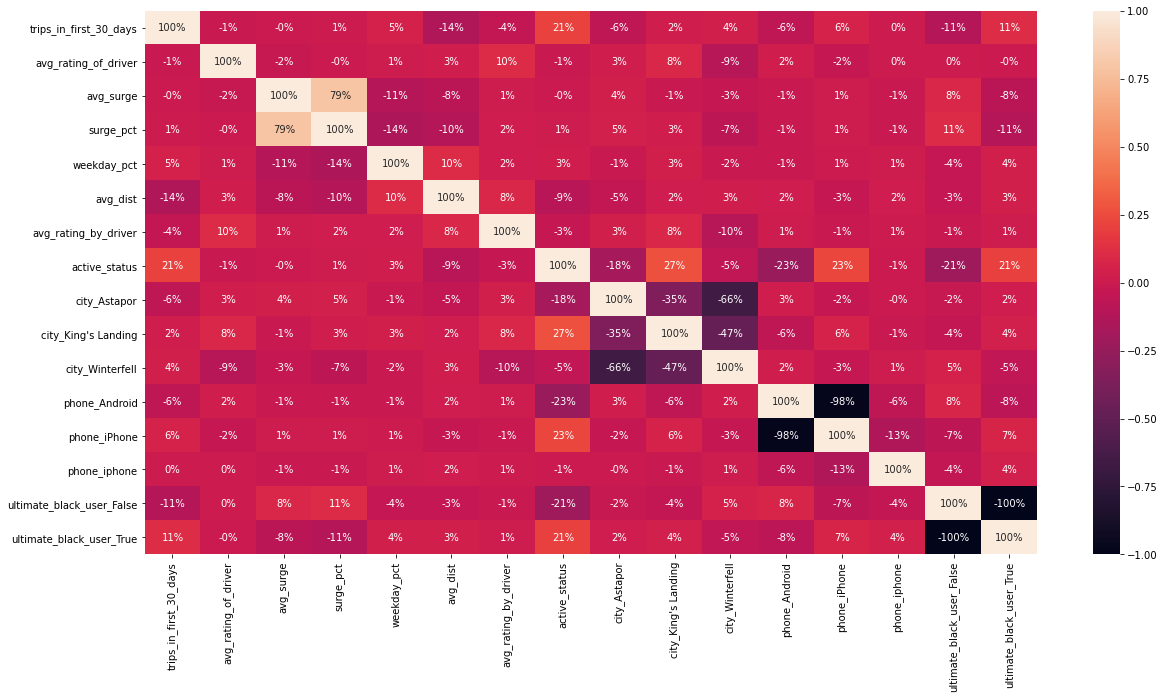

In [44]:
# let visualise correlations between features 

plt.figure(figsize=(20,10))
sns.heatmap(user_data.corr(),annot=True,fmt= '.0%')

In [ ]:
user_data.columns

In [46]:
features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
        'city_Astapor', 
       'city_Winterfell', 'phone_Android', 'phone_iPhone', 'phone_iphone',
       'ultimate_black_user_False', 'ultimate_black_user_True']



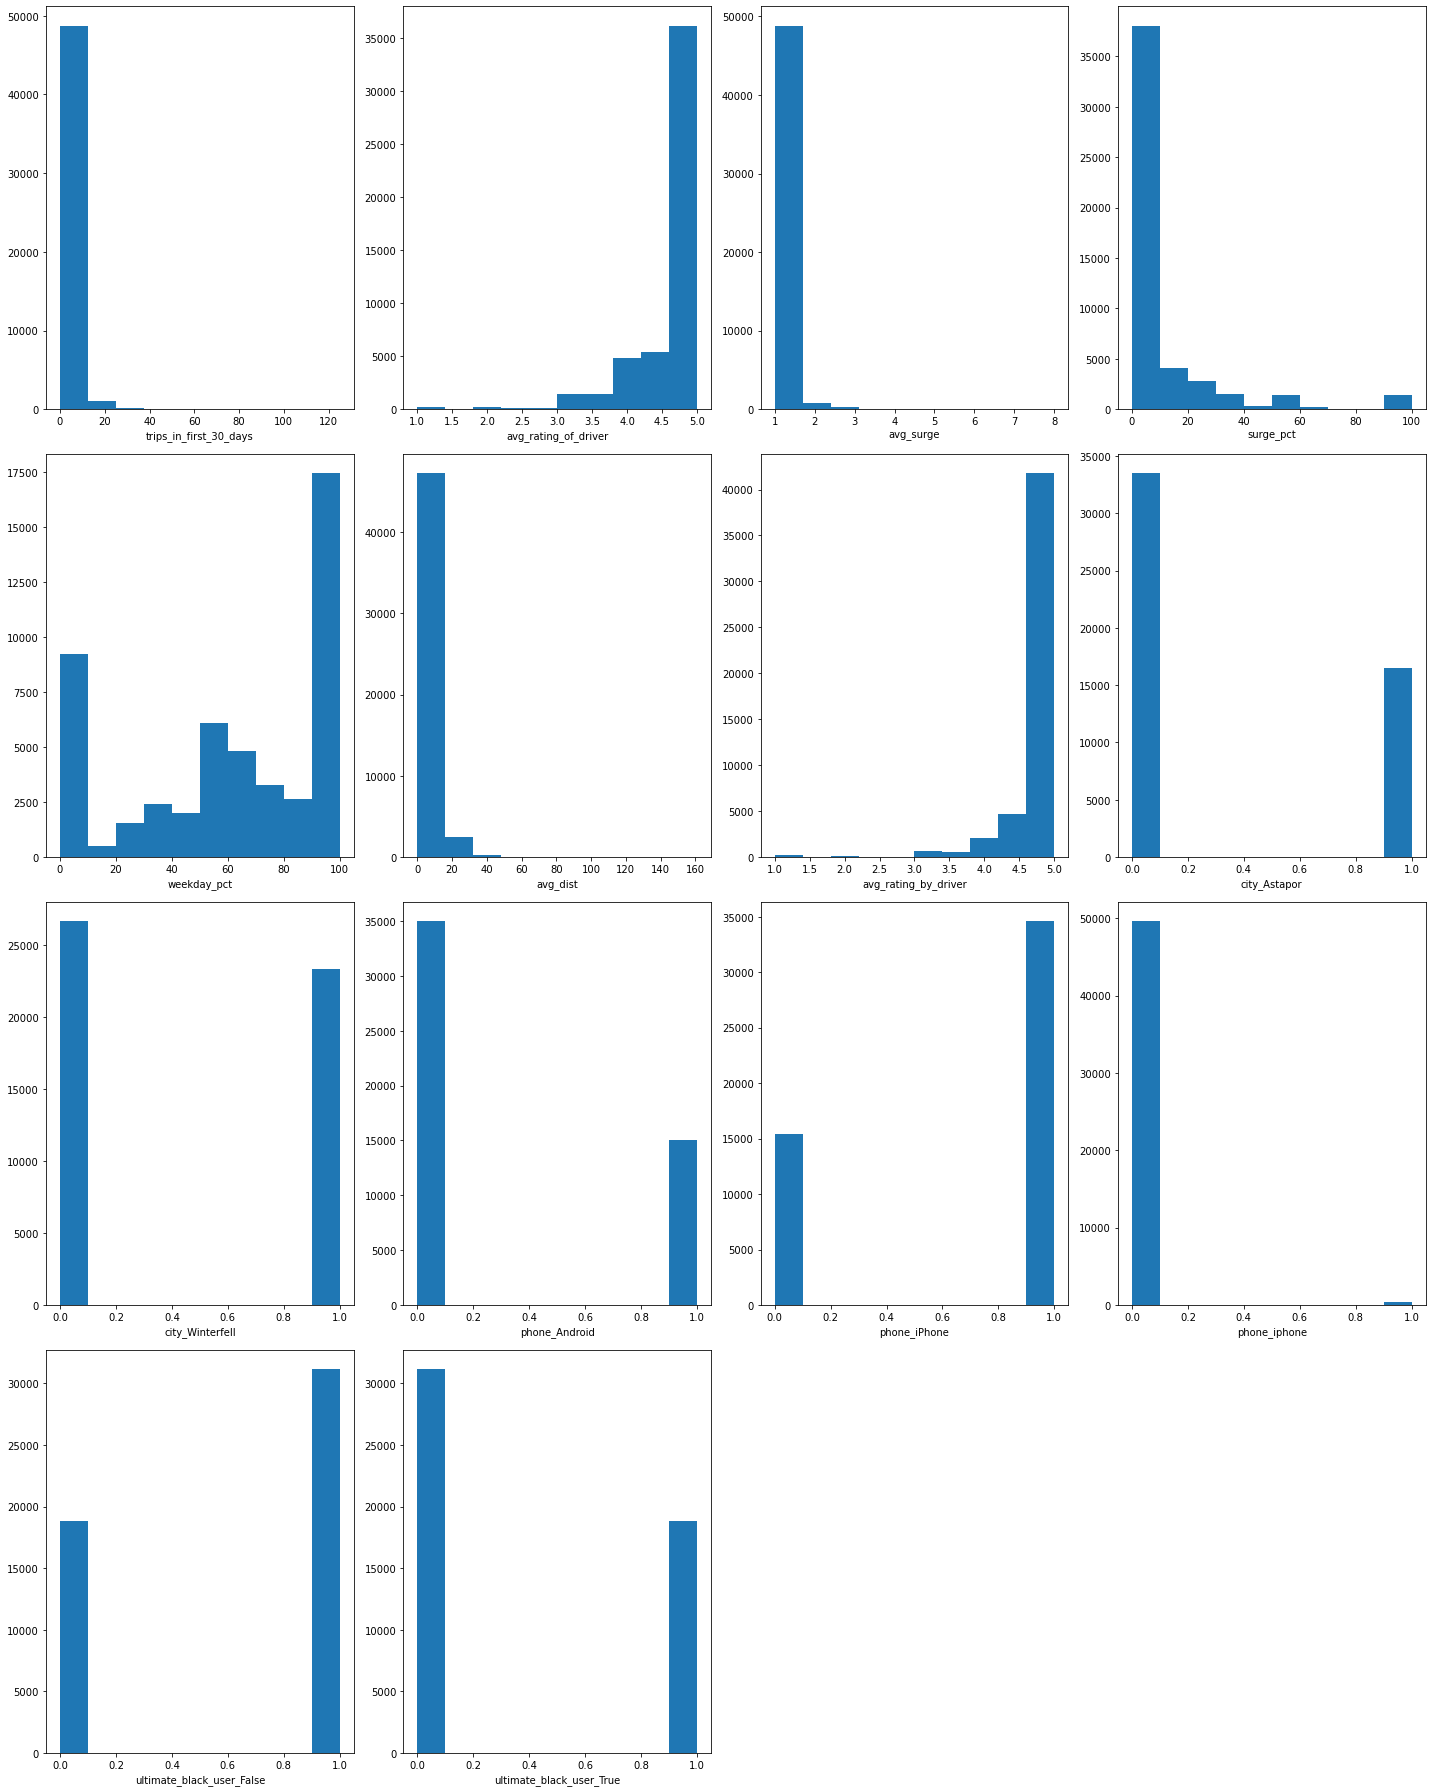

In [47]:

plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in features:
    if plotnumber<=16 :
        ax = plt.subplot(4,4,plotnumber)
        plt.hist(user_data[column])
        plt.xlabel(column)
    plotnumber+=1
plt.tight_layout()

In [76]:
# define features and target
X = user_data[features]
y = user_data.active_status
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_Winterfell,phone_Android,phone_iPhone,phone_iphone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,0,0,1,0,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,1,0,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,1,0,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,0,0,1,0,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,1,1,0,0,1,0


In [78]:
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
X_train.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_Winterfell,phone_Android,phone_iPhone,phone_iphone,ultimate_black_user_False,ultimate_black_user_True
38094,1,5.000000,1.00,0.0,0.0,23.84,5.0,1,0,1,0,0,1,0
40624,1,4.601559,1.00,0.0,0.0,7.74,5.0,1,0,0,1,0,0,1
49425,1,5.000000,1.00,0.0,0.0,4.51,5.0,1,0,1,0,0,1,0
35734,5,4.800000,1.23,14.3,28.6,2.02,4.6,0,1,0,1,0,1,0
41708,7,4.900000,1.00,0.0,70.6,3.15,4.9,0,0,0,1,0,0,1


In [79]:
# instantiate classifier
xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=10, max_depth= 8)

In [80]:
xg_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [82]:
# predict the labels
y_pred = xg_clf.predict(X_test)


In [83]:
# score model
score = accuracy_score(y_test, y_pred)
# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(round(score,4)*100) ,2), "%")

The resulting accuracy of the optimized classifier is 79.0. %


In [84]:
# dictionary of parameters to optimize, and the range of optimization values
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3]
    }


In [86]:
# GridSearchCV
grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster=None,
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=8,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints=None, n_estimators=10,
                                     n_jobs=0, num_parallel_tree=1,
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, silent=1, subsample=1,
                                     tree_method=None,
                                     validate_parameters=False,


In [87]:
# Print best parameters and results
print(grid_search.best_params_)

{'gamma': 2, 'learning_rate': 0.25, 'max_delta_step': 0, 'min_child_weight': 2, 'scale_pos_weight': 0.95, 'subsample': 1}


In [ ]:
xg_clf_optimized = XGBClassifier(gamma = 1, learning_rate= 0.25, max_delta_step= 0, min_child_weight= 2, scale_pos_weight=0.95, subsample= 1)

In [88]:
xg_clf_optimized.fit(X_train,y_train)

NameError: name 'xg_clf_optimized' is not defined

In [ ]:
# predict the labels
y_pred_optimized = xg_clf.predict(X_test)

In [ ]:
# score model
score_optimized = accuracy_score(y_test, y_pred_optimized)
# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(round(score_optimized,4)*100) ,2), "%")

In [ ]:
# save model
pickle.dump(xg_clf_optimized, open('xgboost.pickle', 'wb'))


### Lets discuss the important features now


In [ ]:

plot_importance(xg_clf_optimized)
plot_importance()

## Conclusions

The default parameters produced the best performing XGBoost model, 
esulting in a classification accuracy of 85.43% for the test data. T
he factors that most heavily influence rider retention are the 
average distance in miles per trip taken in the first 30 days 
fter signup and the percent of the user's trips occuring during a weekday.